# **Домашняя работа #3** 

---

### **Выполнил**:  
**Вольхин Данил Федорович**

### **Email**:  
[dfvolkhin@edu.hse.ru](mailto:dfvolkhin@edu.hse.ru)

### **Дата**:  
**14 октября 2024**

---

😊 Третий раз запускаем джупитер и пандас 😊

In [277]:
# Импорт библиотек
import numpy as np
import seaborn as sns
import pandas as pd
import hashlib
from scipy.stats import ttest_ind, mannwhitneyu, rankdata
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.utils import resample
from scipy.special import comb
from matplotlib import pyplot as plt
from scipy.stats import chi2
from typing import Callable
from tqdm import tqdm
import time
from scipy.special import iv

# Задание 1. Про градиентный спуск

Сравнить сложность точного решения задачи линейной регрессии для случая квадратичной ошибки и сложность решения этой же задачи методом градиентного спуска (при условии, что градиентный спуск сходится с K шагов, в задаче есть M признаков и длина обучающей выборки равна N. N>K и N>M)

In [33]:
class LinearRegressionExact:
    """
    Аналитическое решение методом наименьших квадратов.
    """
    # Иницализация параметров
    def __init__(self, device='cpu'):
        self.weights = None
        self.device = device
    
    # Аналитический расчет по формуле
    def fit(self, X, y):
        X, y = X.to(self.device), y.to(self.device)
        self.weights = torch.linalg.inv(X.T @ X) @ (X.T @ y)
    
    # Прогнозирование исходя из посчитанных весов
    def predict(self, X):
        return X.to(self.device) @ self.weights


class LinearRegressionGradientDescent:
    """
    Решение с помощью градиентного спуска.
    """
    # Инициализация параметров
    def __init__(self, learning_rate=0.1, max_iter=1000, tol=1e-2, device='cpu'):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.device = device
        self.weights = None
    
    # Градиентное обновление по формуле
    def fit(self, X, y, exact_weights=None):
        N, M = X.shape
        X, y = X.to(self.device), y.to(self.device)
        self.weights = torch.zeros(M, device=self.device)
        
        # Шаги градиентного спуска
        for i in range(self.max_iter):
            # Градиентное обновление по формуле
            gradient = -2 * X.T @ (y - X @ self.weights) / N
            new_weights = self.weights - self.learning_rate * gradient

            # Проверка сходимости
            if torch.norm(new_weights - self.weights) < self.tol:
                break

            # Проверка на достижение точности аналитического решения
            if exact_weights is not None and torch.allclose(new_weights, exact_weights, atol=self.tol):
                break

            self.weights = new_weights

        return i  # Возвращаем количество итераций
    
    # Прогнозирование исходя из посчитанных весов
    def predict(self, X):
        return X.to(self.device) @ self.weights


class Experiment:
    """
    Класс для проведения эксперимента.
    """
    # Инициализация параметров
    def __init__(self, N, M, K, noise_level=0.1):
        self.N = N
        self.M = M
        self.K = K
        self.noise_level = noise_level
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.X, self.y = self.generate_data()
    
    # Генерация данных
    def generate_data(self):
        torch.manual_seed(42)
        X = torch.randn(self.N, self.M, device=self.device)
        true_weights = torch.randn(self.M, device=self.device)
        y = X @ true_weights + self.noise_level * torch.randn(self.N, device=self.device)
        return X, y
    
    # Выполнение эксперимента
    def run(self):
        # 1. Точное решение
        exact_model = LinearRegressionExact(device=self.device)
        start_time = time.time()
        exact_model.fit(self.X, self.y)
        exact_time = time.time() - start_time
        exact_weights = exact_model.weights

        # 2. Градиентный спуск
        gradient_model = LinearRegressionGradientDescent(max_iter=self.K, device=self.device)
        start_time = time.time()
        gradient_steps = gradient_model.fit(self.X, self.y, exact_weights=exact_weights)
        gradient_time = time.time() - start_time

        return exact_time, gradient_time, gradient_steps
    
    # Построение графика сравнения времени
    @staticmethod
    def plot_results(exact_time, gradient_time):
        methods = ['Аналитический расчет', 'Градиентный спуск']
        times = [exact_time, gradient_time]

        plt.bar(methods, times, color=['blue', 'green'])
        plt.xlabel('Размер рассчетной выборки')
        plt.ylabel('Время (секунды)')
        plt.title(f'Сравнение скорости выполения аналитического решения и градиентного спуска')
        plt.show()

N = 5000: 100%|██████████| 5000/5000 [12:43<00:00,  6.55it/s]


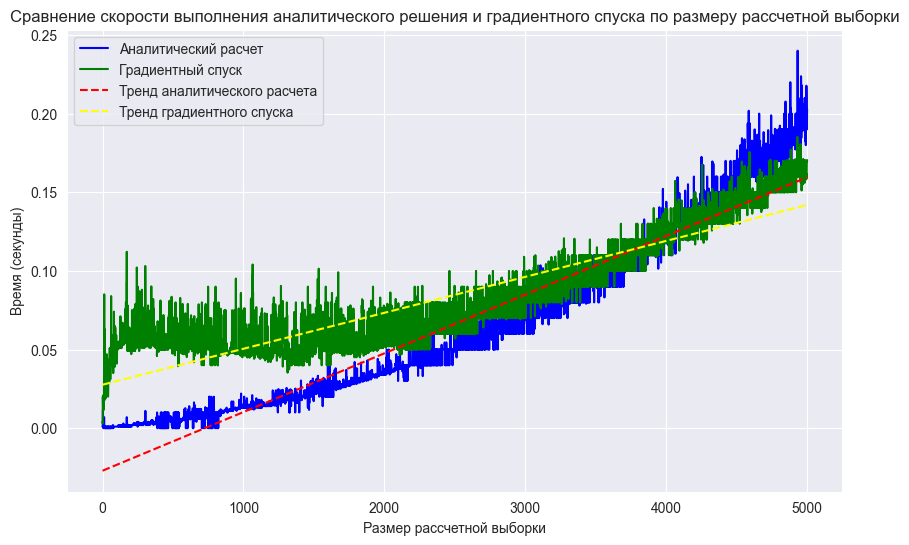

In [36]:
# Параметры эксперимента
num_experiments = 5000  # Количество экспериментов
N = range(1, num_experiments + 1)
M = 2  # Начальное количество признаков
K = 100  # Максимальное количество шагов для градиентного спуска

exact_times = []
gradient_times = []

# Выполнение экспериментов
with tqdm(total=num_experiments) as pbar:
    for n in N:
        M += 1  # Увеличиваем количество признаков
        experiment = Experiment(n, M, K)
        exact_time, gradient_time, _ = experiment.run()
        exact_times.append(exact_time)
        gradient_times.append(gradient_time)
        # Обновление прогресс-бара
        pbar.update(1)
        pbar.set_description(f"N = {n}")

# Построение исходного графика
plt.figure(figsize=(10, 6))
plt.plot(range(num_experiments), exact_times, label="Аналитический расчет", color='blue')
plt.plot(range(num_experiments), gradient_times, label="Градиентный спуск", color='green')

# Линии тренда (аппроксимация 1-й степени - линейная)
exact_trend = np.poly1d(np.polyfit(range(num_experiments), exact_times, 1))  # Линейный тренд для аналитического решения
gradient_trend = np.poly1d(np.polyfit(range(num_experiments), gradient_times, 1))  # Линейный тренд для градиентного спуска

# Построение линий тренда
plt.plot(range(num_experiments), exact_trend(range(num_experiments)), linestyle='--', color='red', label='Тренд аналитического расчета')
plt.plot(range(num_experiments), gradient_trend(range(num_experiments)), linestyle='--', color='yellow', label='Тренд градиентного спуска')

# Оформление графика
plt.xlabel('Размер рассчетной выборки')
plt.ylabel('Время (секунды)')
plt.title('Сравнение скорости выполнения аналитического решения и градиентного спуска по размеру рассчетной выборки')
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

# Вывод по заданию 1. <br/>

#### *Оценка скорости выполнения аналитического решения и градиентного спуска*
Формула для нахождения весов: <br/>
 $ w = (X^TX)^{-1}X^Ty $, где $ X $ - матрица данных размером $ N \times M $, $ y $ - вектор целевых значений размером $ N $ <br/>
 Чтобы найти точное решение: <br/>
   1. Умножение матрицы на ее транспонированную имеет сложжность $ O(N \times M^2) $ <br/>
   2. Обратная матрица $ (X^TX)^{-1} $ размером $ M \times M $ имеет сложжность $ O(M^3) $ <br/>
   3. Умножение обратной матрицы на вектор целевых значений размером $ M $ имеет сложжность $ O(M^2) $ <br/>

Итого общая сложность для точного решения задачи равна $ O(N \times M^2 + M^3 + M^2) $, так как $ N > M $, то сложность можно апроксимипировать как 
$ O(N \times M^2) $ <br/>

Градиентный спуск выполняет итерративное обновление весов по формуле: <br/>
$ w_{t+1} = w_t - \alpha \nabla L(w_t) $, где $ \alpha $ - скорость обучения, $ \nabla L(w_t) $ - градиент функции по весам $ w_t $, где $ ∇𝐿(𝑤)=−2𝑋^𝑇(𝑦−𝑋𝑤) $ <br/> Вычисление градиента: <br/>
1. Нужно умножить матрицу $ 𝑋 $ на вектор $ 𝑤 $, что имеет сложность $ 𝑂(𝑁𝑀) $.
2. Затем вычислить $ 𝑋^𝑇∇𝐿(𝑤)X $ , что также имеет сложность $ 𝑂(𝑁𝑀) $.
3. Шаг градиентного спуска: Каждый шаг градиентного спуска требует $ 𝑂(𝑁𝑀) $ операций.

Пусть градиентный спуск сходится за $ 𝐾 $ шагов. Тогда общая сложность метода градиентного спуска: $ 𝑂(𝐾𝑁𝑀) $ <br/>
<br/>
#### *Сравнение*
Так как $ N > M $, $ N > K $ видно, что: <br/>
* Если $ K << M $, градиентный спуск будет быстрее
* Если $ K \simeq M $, то обе сложности сравнимы

<br/>
#### *Численный эксперимент* <br/>
Скорость выполнения градиентного спуска зависит от количество шагов, которое требуется для сходимости по точности с аналитическим решением. <br/>
Я останавливал расчет градиентного спуска, когда значения весов не отличалась от аналитического решения на 1%. <br/>
С увеличением количества признаков удовлетворялось условие $ K << M $, в целом численный эксперимент подтвердил рассуждения об оценке. 




# Задание 2. Про FWL-Теорему

Возьмите данные c kaggle, например [отсюда](https://www.kaggle.com/code/malakalaabiad/house-prices-techniques/input) и удостоверьтесь, что FWL-теорема работает, но только не для случая одной переменной :)


In [37]:
data = pd.read_csv('C:/Users/NightMare/PycharmProjects/DataAnalysisTools/HomeWork/HW3/boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [40]:
class FWLChecker:
    # Инициализация класса для проверки FWL-теоремы
    def __init__(self, data, target_var, predictors, control_vars):
        self.data = data
        self.target_var = target_var
        self.predictors = predictors
        self.control_vars = control_vars
    
    # Выполнение OLS регрессии
    def run_ols(self, dependent_var, independent_vars):
        X = self.data[independent_vars]
        X = sm.add_constant(X)  # Добавляем константу
        y = self.data[dependent_var]
        model = sm.OLS(y, X).fit()
        return model

    # Запуск полной регрессионной модели
    def full_model(self):
        independent_vars = self.control_vars + self.predictors
        return self.run_ols(self.target_var, independent_vars)
    
    # Получение остатков регрессии
    def residuals(self, dependent_var, independent_vars):
        model = self.run_ols(dependent_var, independent_vars)
        self.data[f'{dependent_var}_resid'] = model.resid
        return model.resid

    # Запуск регрессии на очищенных переменных
    def fwl_detrended_model(self):
        # Получаем остатки для Predictors и Target с учетом Control Variables
        for predictor in self.predictors:
            self.residuals(predictor, self.control_vars)
        self.residuals(self.target_var, self.control_vars)
        # Строим модель на очищенных данных
        detrended_vars = [f'{p}_resid' for p in self.predictors]
        return self.run_ols(f'{self.target_var}_resid', detrended_vars)

    # Сравнение моделей
    def compare_models(self):
        full_model_results = self.full_model()
        detrended_model_results = self.fwl_detrended_model()
        print("Полная модель:")
        print(full_model_results.summary())
        print("\nМодель на очищенных данных:")
        print(detrended_model_results.summary())
        return full_model_results, detrended_model_results

In [42]:
# Создаем объект класса для проверки FWL-теоремы
fwl_checker = FWLChecker(
    data=data, 
    target_var='MEDV', 
    predictors=['RM', 'LSTAT', 'CRIM', 'ZN'],  # Важные предикторы
    control_vars=['AGE', 'TAX', 'INDUS', 'NOX']  # Контрольные переменные
)
# Сравниваем модели
fwl_checker.compare_models()

Полная модель:
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     118.7
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          3.72e-110
Time:                        03:42:31   Log-Likelihood:                -1569.9
No. Observations:                 506   AIC:                             3158.
Df Residuals:                     497   BIC:                             3196.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7275      3.393     

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2591b7b4a30>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2591b7a8a90>)

# Вывод по заданию 2. <br/>

#### *Полная модель и модель на очищенных данных*
Теорема сработала, коэффициенты совпали.

# Задание 3. Про эквивалентность или не эквивалентность разных методов подсчета квантилей

Сгенерируйте 2 выборки длины ,например, 10000 из:

1. Нормального
2. Логнормального
3. Экспоненциального

Распределений с наперед заданными параметрами, так чтобы вы могли однозначно посчитать разницу медиан (используя теорвер и википедию)



Проверьте, какой по этим выборкам будет получаться 95% доверительный интервал на разницу медиан, если его посчитать с помощью:

1. Бутстрепа
2. [Подгонки](https://engineering.atspotify.com/2022/03/comparing-quantiles-at-scale-in-online-a-b-testing/) от Spotify
3. [Подгонки](https://www.evanmiller.org/bootstrapping-sample-medians.html) результатов бутстрепа от Эвана Миллера
4. [Метода Прайса-Боннетта](https://www.tandfonline.com/doi/abs/10.1080/00949650212140)

Что вы можете сказать о работоспособности методов?

(можно попробовать подать на вход какие-то другие распределения, как бы провести "стресс-тест" метода)


In [314]:
class PoissonBootstrapApproximateSampleMedianDistribution:
    # Инициализация параметров 
    def __init__(self, n):
        self.n = n
        self.cdf = self._compute_cdf()
    
    @staticmethod
    def approx_bessel_dist_prob(i, n):
        # Аргумент для функции Бесселя
        arg = 2 * np.sqrt((n + 1 - i) * i)
        # Вероятность на основе функции Бесселя
        return 2 * np.exp(arg - n - 1) * iv(0, arg)

    # Предварительное вычисление CDF
    def _compute_cdf(self):
        cdf = np.zeros(self.n)
        total_sum = 0
        for i in range(1, self.n + 1):
            prob = self.approx_bessel_dist_prob(i, self.n)
            total_sum += prob / (1 - np.exp(-self.n))
            cdf[i-1] = min(1, total_sum)  # Обновляем CDF
        return cdf

    def pdf(self, i):
        return self.approx_bessel_dist_prob(i, self.n)
    
    def cdf(self, i):
        return self.cdf[i-1]
    
    def quantile(self, q):
        if q > self.cdf[-1]:
            return self.n
        else:
            return np.searchsorted(self.cdf, q) + 1  # Индексация с 1

class QuantileComparison:
    # Инициализация параметров
    def __init__(self, sample_size=10000, quantile_of_interest=0.5, alpha=0.05, n_iterations=10000):
        self.sample_size = sample_size
        self.quantile_of_interest = quantile_of_interest
        self.alpha = alpha
        self.n_iterations = n_iterations
        self.distributions = {}
        self.params = {
            'Нормальное': {'loc': 0, 'scale': 1},  # Среднее и стандартное отклонение
            'Логнормальное': {'mean': 0, 'sigma': 1},  # Параметры логнормального распределения
            'Экспоненциальное': {'scale': 1}  # Коэффициент масштаба
        }
    
    # Генерация выборок из нормального, логнормального и экспоненциального распределений
    def generate_samples(self):
        self.distributions['Нормальное'] = np.random.normal(
            loc=self.params['Нормальное']['loc'], 
            scale=self.params['Нормальное']['scale'], 
            size=self.sample_size
        )
        self.distributions['Логнормальное'] = np.random.lognormal(
            mean=self.params['Логнормальное']['mean'], 
            sigma=self.params['Логнормальное']['sigma'], 
            size=self.sample_size
        )
        self.distributions['Экспоненциальное'] = np.random.exponential(
            scale=self.params['Экспоненциальное']['scale'], 
            size=self.sample_size
        )
    
    # Расчет теоретической медианы для каждого распределения
    def theoretical_median(self, dist):
        if dist == 'Нормальное':
            return self.params['Нормальное']['loc']
        elif dist == 'Логнормальное':
            return np.exp(self.params['Логнормальное']['mean'])
        elif dist == 'Экспоненциальное':
            return self.params['Экспоненциальное']['scale'] * np.log(2)
    
    # Расчет теоретической разницы медиан между двумя распределениями
    def theoretical_median_difference(self, dist1, dist2):
        median1 = self.theoretical_median(dist1)
        median2 = self.theoretical_median(dist2)
        return median1 - median2
    
    # Бутстреп оценка доверительного интервала
    def bootstrap_confidence_interval(self, dist1, dist2):
        start_time = time.time()
        differences = []
        for _ in range(self.n_iterations):
            sample1 = resample(self.distributions[dist1])
            sample2 = resample(self.distributions[dist2])
            differences.append(np.median(sample1) - np.median(sample2))
        lower_bound = np.percentile(differences, (100 * self.alpha) / 2)
        upper_bound = np.percentile(differences, 100 * (1 - self.alpha / 2))
        exact_time = time.time() - start_time
        return lower_bound, upper_bound, exact_time
    
    # Метод подгонки от Spotify
    def spotify_quantile_fit(self, dist1, dist2):
        start_time = time.time()
        outcome_control_sorted = np.sort(self.distributions[dist2])
        outcome_treatment_sorted = np.sort(self.distributions[dist1])
        # Генерация бутстреп-выборок
        control_quantiles = outcome_control_sorted[
            np.random.binomial(self.sample_size + 1, self.quantile_of_interest, self.n_iterations)]
        treatment_quantiles = outcome_treatment_sorted[
            np.random.binomial(self.sample_size + 1, self.quantile_of_interest, self.n_iterations)]
        bootstrap_diff = treatment_quantiles - control_quantiles
        # Вычисление доверительного интервала
        bootstrap_conf_interval = np.percentile(bootstrap_diff, [self.alpha / 2 * 100, (1 - self.alpha / 2) * 100])
        lower_bound = bootstrap_conf_interval[0]
        upper_bound = bootstrap_conf_interval[1]
        # Возвращение разницы квантили
        exact_time = time.time() - start_time
        return lower_bound, upper_bound, exact_time
    
    # Подгонка бутстрепа от Эвана Миллера
    def evan_miller_bootstrap_fit(self, dist1, dist2):
        start_time = time.time()
        # Создаем объект для распределений
        evan_miller_dist1 = PoissonBootstrapApproximateSampleMedianDistribution(len(self.distributions[dist1]))
        evan_miller_dist2 = PoissonBootstrapApproximateSampleMedianDistribution(len(self.distributions[dist2]))
        differences = []
        # Генерируем бутстреп выборки
        for _ in range(self.n_iterations):
            # Нормализуем вероятности для выборки
            cdf1 = evan_miller_dist1.cdf / evan_miller_dist1.cdf.sum()
            cdf2 = evan_miller_dist2.cdf / evan_miller_dist2.cdf.sum()
            # Теперь можно использовать нормализованные значения
            sample1_indexes = np.random.choice(np.arange(len(self.distributions[dist1])), size=self.sample_size, p=cdf1)
            sample2_indexes = np.random.choice(np.arange(len(self.distributions[dist2])), size=self.sample_size, p=cdf2)
            # Находим медианы выборок и вычисляем разницу
            diff = np.median(self.distributions[dist1][sample1_indexes]) - np.median(self.distributions[dist2][sample2_indexes])
            differences.append(diff)
        # Вычисляем доверительные интервалы
        lower_bound = np.percentile(differences, self.alpha / 2 * 100)
        upper_bound = np.percentile(differences, (1 - self.alpha / 2) * 100)
        exact_time = time.time() - start_time
        return lower_bound, upper_bound, exact_time
    
    @staticmethod
    def var_price_bonett(sample):
        n = len(sample)
        c = (n + 1) / 2 - np.sqrt(n)
        if n > 100:
            z = 2
        else:
            log_p = 0  # Логарифм p
            for index in range(0, int(c - 1)):
                # Используем функцию comb для вычисления биномиальных коэффициентов
                fact = comb(n, index, exact=True)  # exact=True для работы с целыми числами
                log_p += np.log(fact) + np.log(n - index) + (n - index) * np.log(0.5)
            p = np.exp(log_p)  # Конвертируем обратно в обычное число
            z = stats.norm.ppf(1 - p / 2)
        var = (sample[int((n - c + 1))] - sample[int(c)]) / (2 * z)
        return var
    
    # Метод Прайса-Боннетта
    def price_bonett_method(self, dist1, dist2):
        start_time = time.time()
        # Бутстреп выборки для оценки разницы медиан
        sample1 = self.distributions[dist1]
        sample2 = self.distributions[dist2]
        z = stats.norm.ppf(1 - self.alpha / 2)
        lower_bound_arr = []
        upper_bound_arr = []
        for _ in range(self.n_iterations):
            # Получаем выборку
            n_sample1 = np.sort(resample(sample1))
            n_sample2 = np.sort(resample(sample2))
            var1 = self.var_price_bonett(n_sample1)
            var2 = self.var_price_bonett(n_sample2)
            interval = z * np.sqrt(var1 + var2)
            median = np.median(n_sample1) - np.median(n_sample2)
            lower_bound = median - interval / 10
            upper_bound = median + interval / 10
            lower_bound_arr.append(lower_bound)
            upper_bound_arr.append(upper_bound)
        lower_bound = np.mean(lower_bound_arr)
        upper_bound = np.mean(upper_bound_arr)
        exact_time = time.time() - start_time
        return lower_bound, upper_bound, exact_time
    
    # Запуск расчета для всех методов
    def run_analysis(self):
        self.generate_samples()
        results = []
        comparisons = [('Нормальное', 'Логнормальное'), ('Логнормальное', 'Экспоненциальное'), ('Нормальное', 'Экспоненциальное')]
        with tqdm(total=len(comparisons), unit='расчет') as pbar:
            for dist1, dist2 in comparisons:
                theoretical_diff = self.theoretical_median_difference(dist1, dist2)
                row = {
                    'Эксперимент': f'{dist1} vs {dist2}',
                    'Теоретическая разница медиан': theoretical_diff,
                    'Бутстреп': self.bootstrap_confidence_interval(dist1, dist2),
                    'Подгонки от Спотифай': self.spotify_quantile_fit(dist1, dist2),
                    'Подгонки от Эвана Миллера': self.evan_miller_bootstrap_fit(dist1, dist2),
                    'Метод Прайса-Боннетта': self.price_bonett_method(dist1, dist2)
                }
                results.append(row)
                pbar.update(1)
                pbar.set_description(f"Расчет для {dist1} vs {dist2}")
        return pd.DataFrame(results)
    
    # Расчет ошибок для каждого метода
    @staticmethod
    def calculate_errors(df):
        df['Бутстреп ошибка'] = df['Бутстреп'].apply(lambda ci: (ci[1] - ci[0]) / 2)
        df['Спотифай ошибка'] = df['Подгонки от Спотифай'].apply(lambda ci: (ci[1] - ci[0]) / 2)
        df['Подгонки от Эвана Миллера ошибка'] = df['Подгонки от Эвана Миллера'].apply(lambda ci: (ci[1] - ci[0]) / 2)
        df['Метод Прайса-Боннетта ошибка'] = df['Метод Прайса-Боннетта'].apply(lambda ci: (ci[1] - ci[0]) / 2)
        return df
    
    # Графическое отображение доверительных интервалов и теоретических значений
    @staticmethod
    def plot_confidence_intervals(df):
        comparisons = df['Эксперимент']
        theoretical_diffs = df['Теоретическая разница медиан']
        n_comparisons = len(comparisons)
        fig, ax = plt.subplots(nrows=n_comparisons, ncols=1, figsize=(10, 5 * n_comparisons))
        for i, comparison in enumerate(comparisons):
            theoretical = theoretical_diffs[i]
            bootstrap_ci = df['Бутстреп'][i]
            spotify_ci = df['Подгонки от Спотифай'][i]
            evan_miller_ci = df['Подгонки от Эвана Миллера'][i]
            price_bonett_ci = df['Метод Прайса-Боннетта'][i]
            methods = ['Бутстреп', 'Подгонки от Спотифай', 'Подгонки от Эвана Миллера', 'Метод Прайса-Боннетта']
            intervals = [bootstrap_ci, spotify_ci, evan_miller_ci, price_bonett_ci]
            ax[i].hlines(y=theoretical, xmin=-0.5, xmax=3.5, color='green', linestyle='--')  # Линия теоретического значения
            for j, (method, interval) in enumerate(zip(methods, intervals)):
                center = (interval[0] + interval[1]) / 2 if interval[0] != interval[1] else interval[0]
                ax[i].plot([j, j], [interval[0], interval[1]], color='blue', linewidth=3)
                ax[i].scatter(j, center, color='red', zorder=5)
            ax[i].set_xticks(range(0, 4))
            ax[i].set_xticklabels(methods)
            ax[i].set_title(f'Эксперимент: {comparison}')
            ax[i].set_ylabel('Разница значений медиан')
            ax[i].legend(['Теоретическое значение', 'Доверительный интервал', 'Центральная точка интервала'], loc='upper right')        
        plt.tight_layout()
        plt.show()
        plt.close()

In [315]:
# Пример использования
quantile_comparator = QuantileComparison()
results = quantile_comparator.run_analysis()
results_with_errors = quantile_comparator.calculate_errors(results)

  0%|          | 0/3 [00:00<?, ?расчет/s]C:\Temp\ipykernel_14656\2239017689.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  return 2 * np.exp(arg - n - 1) * iv(0, arg)
Расчет для Нормальное vs Экспоненциальное: 100%|██████████| 3/3 [02:18<00:00, 46.09s/расчет]   


In [316]:
# Вывод результатов
results_with_errors.head()

,Эксперимент,Теоретическая разница медиан,Бутстреп,Подгонки от Спотифай,Подгонки от Эвана Миллера,Метод Прайса-Боннетта,Бутстреп ошибка,Спотифай ошибка,Подгонки от Эвана Миллера ошибка,Метод Прайса-Боннетта ошибка
0,Нормальное vs Логнормальное,-1.000000,"(-1.0521919271512394, -0.9848744923742437, 7.6...","(-1.052079765229646, -0.9863892816088249, 0.00...","(-1.052076643061569, -0.9860401518996533, 22.9...","(-1.0487568360519028, -0.988426025972673, 15.9...",0.033659,0.032845,0.033018,0.030165
1,Логнормальное vs Экспоненциальное,0.306853,"(0.2824223567429309, 0.34982851595373726, 7.20...","(0.28308421377228826, 0.3493390432668821, 0.00...","(0.2812374285433812, 0.34916834402566604, 23.1...","(0.2856792469790906, 0.3456201309226918, 15.49...",0.033703,0.033127,0.033965,0.029970
2,Нормальное vs Экспоненциальное,-0.693147,"(-0.7341409650615619, -0.6711037362482304, 7.5...","(-0.7346295029545077, -0.670588314074272, 0.0)","(-0.7346598101321216, -0.6710038114746862, 22....","(-0.732660335504294, -0.6736455956709266, 15.6...",0.031519,0.032021,0.031828,0.029507


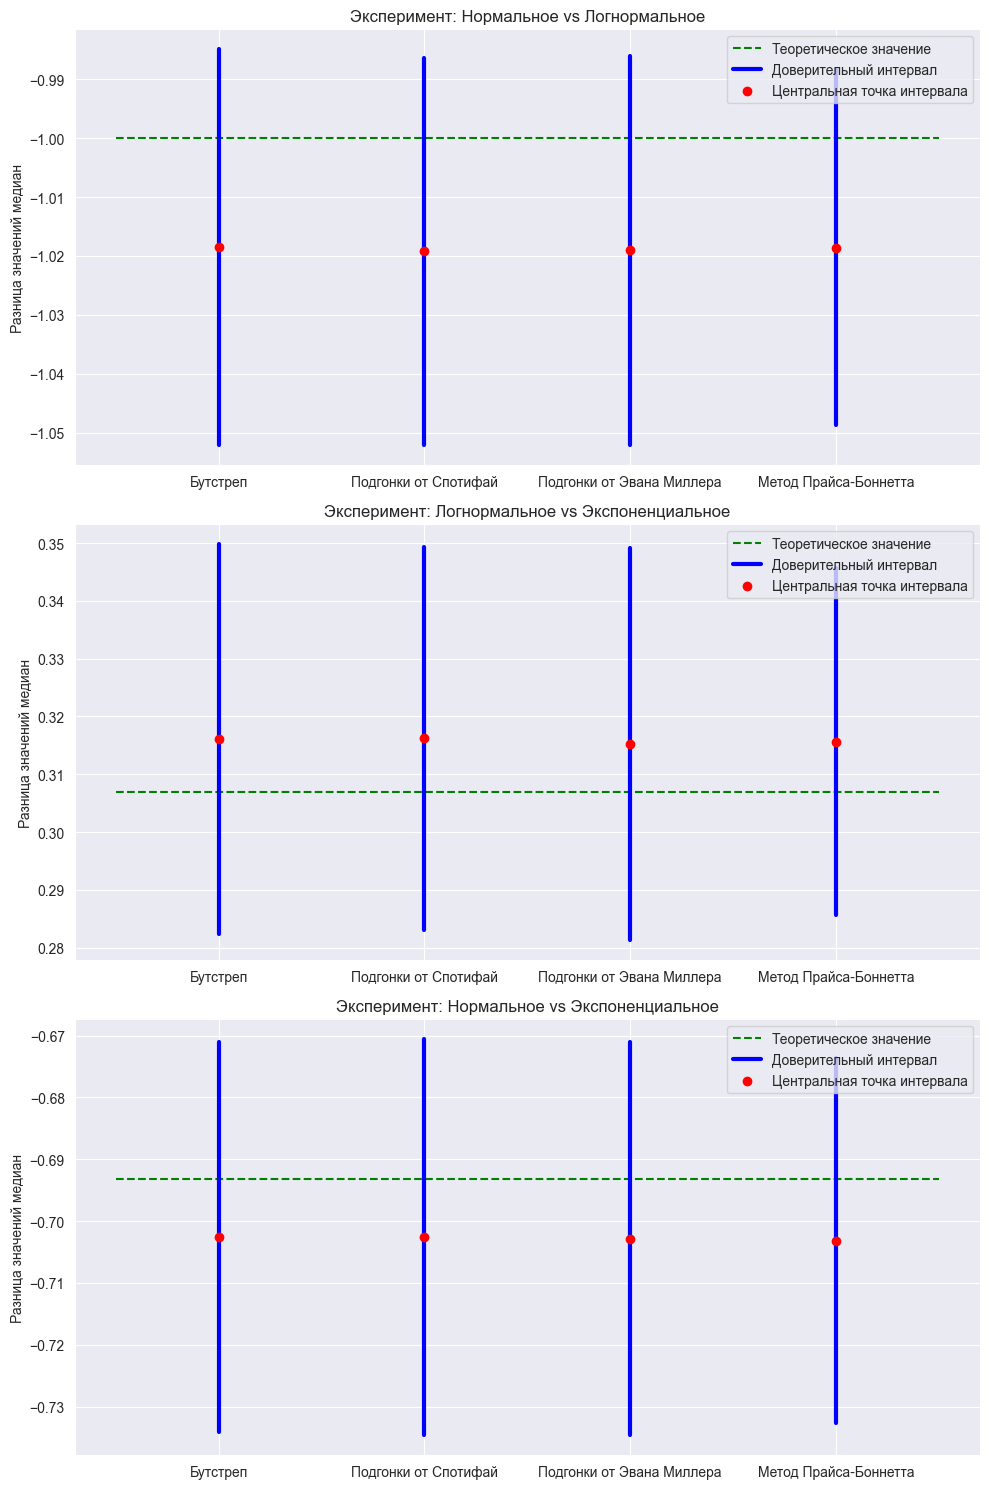

In [317]:
# Визуализация доверительных интервалов
quantile_comparator.plot_confidence_intervals(results_with_errors)

# Вывод по заданию 3. <br/>

 *Формулы Прайса-Боннета* <br/>
 *$ (\hat{\eta_{1}} - \hat{\eta_{2}}) \pm z_{\frac{\alpha}{2}} \sqrt{var(\hat{\eta_{1}})+var(\hat{\eta_{2}})}$* <br/>
 *$ var(\hat{\eta_{j}}) = (\frac{(Y_{(n_j - c_j + 1)j} - Y_{(cj)j})}{2z_j})^2 $* <br/>
 *$ c_j = \frac{(n_j + 1)}{2} - n_{j}^{1/2} $* <br/>
 *$ z_j = \Phi^{-1}(1 - p_j/2) $* <br/>
 *$ p_j = \sum_{i=0}^{c-1}{{\frac{n!}{i!}(n-i)!}(0.5)^{(n-i)}} $* <br/>
 *$ P(Y_{(cj)j} < \hat{\eta_{j}} < Y_{(n_j - c_j + 1)j}) = 1 - p_j $* <br/>
 *Для больших $ n_j $ устанвливается $ z_j = 2 $* <br/>

 <br/>

#### Сравнение
Все методы дают одинаково близкие доверительные интервалы и охватывают теоретическое значение разницы медиан, но они отличаются по скорости выполнения.
Составленный топ методов по скорости выполнения:
1. Метод подгонки Spotfy (2*10^-3 секунды)
2. Бутстреп (7 секунд)
3. Метод Прайса-Боннетта (15 секунд)
4. Подгонки от Эвана Миллера (22 секунды)

<br/>
Есть проблемы с переполнением памяти для метода Прайса-Боннетта, в статье указано, что при large выборках z=2  <br/>
я так и не разобрался 10000 это много? Там вся проблема в формуле с факториалами, как брать факторилалы от 10000 не понятно. <br/>
Более чем уверен, что не каждый метрод будет работать всегда)